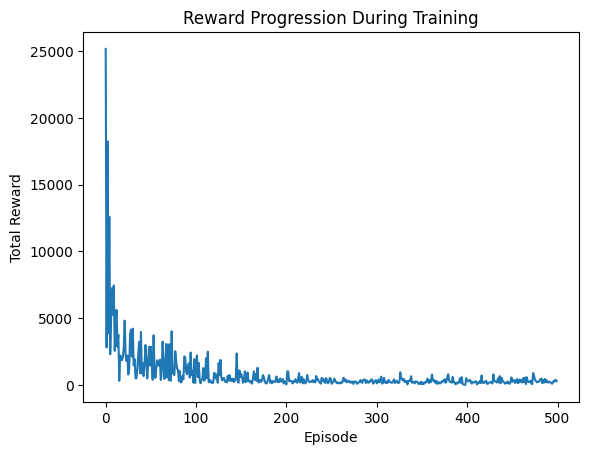

Minimum maximum time achieved: 7


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict
import random

# Grid dimensions and initialization
grid_size = 10
grid = np.zeros((grid_size, grid_size), dtype=int)

# Define obstacles (1 indicates a wall)
obstacles = [
    (0, 4), (1, 4), (2, 4), (2, 5),
    (4, 7), (4, 8), (4, 9), (5, 7),
    (4, 0), (4, 1), (4, 2), (5, 2),
    (7, 5), (8, 5), (9, 5), (7, 4)
]
for obstacle in obstacles:
    grid[obstacle] = 1

# Define goals (3 indicates a destination)
goals = [(5, 8), (8, 4), (1, 5), (5, 1)]

# Visualization helpers
agent_colors = ['green', 'purple', 'cyan', 'yellow']

def plot_grid(grid, agents, goals, title="Grid Visualization"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)

    # Draw the grid
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] == 1:  # Walls
                ax.add_patch(patches.Rectangle((y, grid_size-x-1), 1, 1, color='brown'))
            elif (x, y) in agents:  # Agents
                agent_index = agents.index((x, y))
                ax.add_patch(patches.Circle((y+0.5, grid_size-x-1+0.5), 0.3, color=agent_colors[agent_index]))
            elif (x, y) in goals:  # Goals
                agent_index = goals.index((x, y))
                ax.plot(y+0.5, grid_size-x-1+0.5, marker='x', color=agent_colors[agent_index], markersize=15, markeredgewidth=3)

    # Draw grid lines
    for i in range(grid_size+1):
        ax.plot([0, grid_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, grid_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(title)
    plt.show()

# Multi-agent environment
class MultiAgentGridMinMax:
    def __init__(self, grid, goals, num_agents):
        self.grid = grid
        self.goals = goals
        self.num_agents = num_agents
        self.state = tuple([None] * num_agents)  # Placeholder for agent states
        self.steps_taken = [0] * self.num_agents

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < grid_size and 0 <= y < grid_size and self.grid[x, y] != 1

    def reset(self):
        # Randomize agent positions each time
        agents = []
        while len(agents) < self.num_agents:
            x, y = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
            if self.grid[x, y] == 0 and (x, y) not in agents:  # Ensure the position is free and unique
                agents.append((x, y))
        self.state = tuple(agents)
        self.steps_taken = [0] * self.num_agents
        return self.state

    def step(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            # Check validity and ensure no overlap
            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos

            # Increment step count
            self.steps_taken[i] += 1

            # Calculate reward
            if new_pos == self.goals[i]:
                reward = 10  # Goal reward
            else:
                reward = -1  # Step penalty
            rewards.append(reward)

        self.state = tuple(next_state)
        done = all(next_state[i] == self.goals[i] for i in range(self.num_agents))
        return self.state, rewards, done, max(self.steps_taken)

# Parameters
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # [Stay, Up, Down, Left, Right]
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9
ALPHA = 0.1
EPSILON = 0.2
MAX_EPISODES = 500

# Q-learning with min-max time
def train_agents_minmax(grid_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(grid_env.num_agents)]
    min_max_time = float('inf')
    rewards_per_episode = []

    for episode in range(MAX_EPISODES):
        state = grid_env.reset()
        total_reward = 0
        done = False

        while not done:
            actions = []
            for i in range(grid_env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)

            next_state, rewards, done, max_time = grid_env.step(actions)
            total_reward += sum(rewards)

            # Update Q-tables
            for i in range(grid_env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            state = next_state

        rewards_per_episode.append(total_reward)
        min_max_time = min(min_max_time, max_time)

    # Plot rewards
    plt.plot(rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Progression During Training')
    plt.show()

    return q_tables, min_max_time

# Train and visualize results
grid_env = MultiAgentGridMinMax(grid, goals, num_agents=4)
q_tables, min_max_time = train_agents_minmax(grid_env)

print(f"Minimum maximum time achieved: {min_max_time}")
